In [2]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [3]:
# Load data
df = pd.read_csv(r"./data/player_hist_df.csv")
players_df = pd.read_csv(r"./data/curr_player_df.csv")

In [4]:
# Clean
df = df.drop("Unnamed: 0", axis=1)

In [5]:
# Filter for attackers that have played minutes
df = df[df['position'].isin(['Forward', 'Midfielder'])]
df = df[df['minutes'] != 0]

In [6]:
# Compare previous season's stats to next season's points by shifting df
shifted = df.groupby('id')[['goals_scored', 'assists', 'goals_conceded',
                            'bps', 'clean_sheets', 'saves',
                            'influence', 'creativity', 'threat', 
                            'minutes', 'end_cost']].shift()

shifted = shifted.join(df[['id', 'total_points', 'season_name']]).dropna(subset=['minutes'])

shifted[['influence', 'creativity', 'threat']] = shifted[['influence', 'creativity', 'threat']].astype(float)

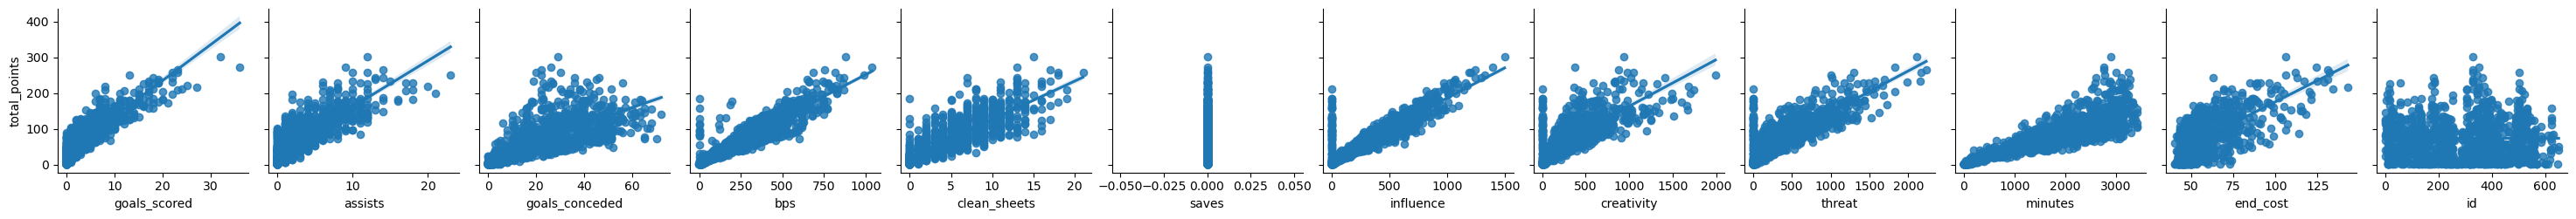

In [7]:
sns.pairplot(df, x_vars=shifted.drop(["total_points", "season_name"], axis=1), 
             y_vars="total_points", kind="reg")

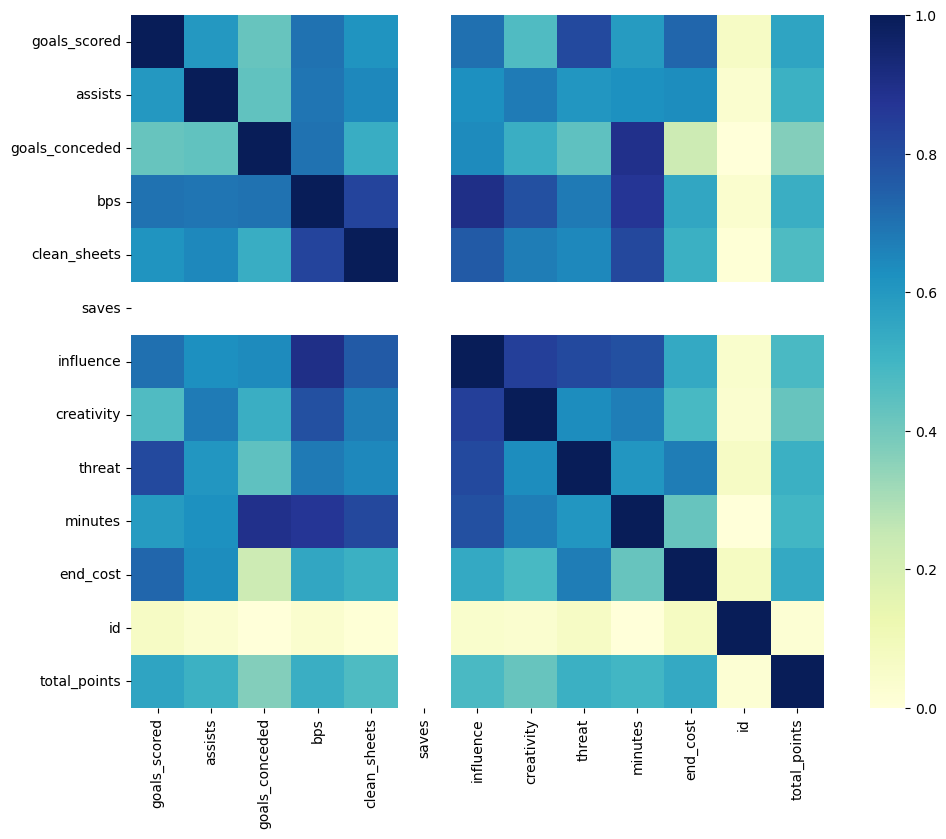

In [8]:
corrmat = shifted.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmin=0, vmax=1, square=True, cmap="YlGnBu", ax=ax)
plt.show()

In [9]:
# Create inputs and outputs
y = shifted[['total_points', 'season_name']]
x = shifted.drop(['total_points', 'id', 'bps', 'goals_conceded', 'clean_sheets', 'saves'], axis=1)

In [10]:
# Define a list of models to evaluate
scaler = MinMaxScaler()
models = [('reg', LinearRegression()), ('xgb', xgb.XGBRegressor())]
results = []
names = []

In [11]:
# Train on season's before 23/24
# Validate on 22/23 stats for 23/24 points
X_train = x[x['season_name'] != '2023/24'].drop('season_name', axis=1)
X_test =  x[x['season_name'] == '2023/24'].drop('season_name', axis=1)
y_train = y[y['season_name'] != '2023/24'].drop('season_name', axis=1)
y_test = y[y['season_name'] == '2023/24'].drop('season_name', axis=1)

In [12]:
# Predict on 24/25 stats from 23/24 points
next_season = df[df['season_name']=='2023/24'][['goals_scored', 'assists',
                                                'influence', 'creativity', 'threat', 
                                                'minutes', 'end_cost']]

In [13]:
# Predict on 24/25 stats from 23/24 points
pred_next = df[df['season_name']=='2023/24']

In [14]:
# Loop through each model, fit it to the data, and calculate the RMSE

for name, model in models:
    
    model.fit(scaler.fit_transform(X_train), y_train)
    
    y_val = model.predict(scaler.fit_transform(X_test))
    result = np.sqrt(mean_squared_error(y_test, y_val))
    results.append(result)
    names.append(name)
    msg = "%s: MSE : %f" % (name, result)
    print(msg)
    print("R2 : " + str(r2_score(y_test, y_val)))
    
    y_pred = model.predict(scaler.fit_transform(next_season))
    pred_next["predicted_score_"+name] = y_pred

reg: MSE : 43.576645
R2 : 0.37795218242772255
xgb: MSE : 46.943453
R2 : 0.27811793413041863


/var/folders/w0/xzc2fzv12z17ysj9jmrjk9v80000gn/T/ipykernel_98859/3327617047.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_next["predicted_score_"+name] = y_pred
/var/folders/w0/xzc2fzv12z17ysj9jmrjk9v80000gn/T/ipykernel_98859/3327617047.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_next["predicted_score_"+name] = y_pred


In [15]:
pred_next[['id', 
           'predicted_score_reg', 
           'predicted_score_xgb']].merge(players_df[['first_name',
                                                     'now_cost',
                                                     'points_per_game', 
                                                     'second_name',
                                                     'selected_by_percent', 
                                                     'total_points',
                                                     'id']], on='id').sort_values('predicted_score_reg', 
                                                                                  ascending=False).nlargest(50,
                                                                                                            columns='predicted_score_reg')

id  predicted_score_reg  predicted_score_xgb       first_name  now_cost  \
155  351           221.748258           187.781891           Erling       153   
145  328           203.937381           202.470947          Mohamed       128   
23    58           193.533701           108.098793            Ollie        90   
218  503           178.109673           190.394577              Son       100   
8     17           173.594694            82.706985           Bukayo       101   
153  348           166.652906           106.691818             Phil        92   
85   182           162.030991            91.531029             Cole       107   
179  401           154.646960           128.147827        Alexander        83   
205   82           153.296323           100.034233          Dominic        76   
6     13           152.573071           109.467880           Martin        82   
178  398           149.992690           146.050140          Anthony        73   
163  366           149.745870           104.160187            Bruno        82   
225  514           149.569114           114.039749           Jarrod        74   
2      4           148.573677           122.662392              Kai        82   
156  352           141.937378           128.239746           Julián        70   
83   180           140.222580           134.038330          Nicolas        78   
136  316           138.366001           154.104401           Darwin        72   
144  327           136.143346           124.511627             Luis        80   
151  345           129.814402           191.993240            Kevin        95   
194  433           127.381099            71.795166           Morgan        63   
94   207           124.976948           134.413086    Jean-Philippe        74   
213  494           123.912578           100.787422            James        75   
228  525           121.610678           122.071289         Mohammed        63   
173  385           121.597472           127.960114           Marcus        69   
62   125           120.771095            22.518616           Pascal        65   
12    28           120.561807           133.090256             Leon        64   
211  492           120.561137           158.088089            Dejan        62   
15    34           120.116116           125.339424           Moussa        65   
11   186           120.097116           148.561676           Raheem        68   
53   110           119.748907            68.106750            Yoane        60   
47    99           119.276196            94.325356            Bryan        74   
235  541           118.241367           162.010330          Matheus        65   
137  317           118.167688           103.025612            Diogo        75   
177  394           118.081803           114.642685            Bruno        63   
168  375           117.181117           110.680542           Rasmus        69   
210  491           117.139692           118.852203          Brennan        64   
4      9           116.595759           153.004715          Gabriel        69   
149  342           116.574784            86.434036         Bernardo        65   
91   199           114.897937           143.627045         Eberechi        68   
199  531           114.247133           125.040375            James        62   
160  360           114.055615           105.447083  Rodrigo 'Rodri'        63   
166  372           114.004708           121.283325        Alejandro        63   
7     16           113.061597           116.004608           Declan        63   
115  240           112.520376            38.566994          Andreas        53   
10    23           111.144635            94.520401          Leandro        69   
78   169           110.436293           133.766968            Conor        59   
240  550           110.074567           115.179253            Hwang        62   
214  497           109.449408           124.967499      Richarlison        68   
109  230           109.329347        